In [37]:
import re, sys, os
import sqlite3
import struct, socket, json
from graphviz import Digraph
from canonical_tree_edit import CallGraph, index_of, index_of_memo

In [38]:
syscall_re = re.compile("SYSCALL (?P<internal_uuid>[0-9-]+) (?P<issuing_thread_tid>[0-9-]+) (?P<issuing_process_pid>[0-9-]+) (?P<local_id>[0-9-]+) (?P<syscall_number>[0-9-]+) (?P<arg0>[0-9-]+) (?P<arg1>[0-9-]+) (?P<arg2>[0-9-]+) (?P<arg3>[0-9-]+) (?P<arg4>[0-9-]+) (?P<arg5>[0-9-]+) (?P<retval>[0-9-]+) (?P<was_successful>[0-9-]+)")

sockop_re = re.compile("\s+sockop (?P<socket_internal_id>\d+)")
serversock_re = re.compile("\s+serversock (?P<socket_internal_id>\d+)")

sock_re = re.compile("SOCK (?P<internal_id>[0-9-]+) (?P<flags>[0-9-]+) (?P<file_descriptor>[0-9-]+) (?P<owner>[0-9-]+) (?P<creator>[0-9-]+)")

#process_re = re.compile("PROCESS (?P<internal_id>[0-9-]+) (?P<process_id>[0-9-]+) (?P<exit_code>[0-9-]+) (?P<did_exit>[0-9-]+) (?P<thread_cnt>[0-9-]+>) (?P<command_line>[a-zA-Z0-9._\-/]+)") 
process_re = re.compile("PROCESS (?P<internal_id>[0-9-]+) (?P<process_id>[0-9-]+) (?P<exit_code>[0-9-]+) (?P<did_exit>[0-9-]+) (?P<thread_cnt>\d+) (?P<command_line>\S+)") 

thread_re = re.compile("THREAD (?P<internal_id>[0-9-]+) (?P<thread_id>[0-9-]+) (?P<process_internal_id>[0-9-]+) (?P<event_cnt>[0-9-]+)")

event_re = re.compile("\s*EVENT (?P<internal_perthread_id>[0-9-]+) (?P<thread_internal_id>[0-9-]+) (?P<syscall_internal_id>[0-9-]+) (?P<was_syscall_entry>[0-9-]+) (?P<additional_parent_cnt>[0-9-]+)")

subevent_re = re.compile("\s+event (?P<parent_thread_event_id>[0-9-]+) (?P<parent_thread_id>[0-9-]+)")

# addr sockaddr_in (16)53940:127.0.0.1
peer_re = re.compile("\s+(?P<type>peer|addr)\s+sockaddr_in\s+\((?P<descriptor>\d+)\)(?P<port>\d+):(?P<ip>[0-9\.]+)")

conn_re = re.compile("CONN (?P<internal_id>[0-9-]+) (?P<connector_socket_id>[0-9-]+) (?P<acceptor_socket_id>[0-9-]+) (?P<connect_syscall_id>[0-9-]+) (?P<accept_syscall_id>[0-9-]+)")

is_int = re.compile('[0-9\-]+')

In [39]:
def quoted(st):
    #if is_int.match(st):
    if st.isdigit():
        return st
    else:
        return '"' + st + '"'

class Syscalls():
    def __init__(self):
        self.syscalls = {}
        kvre = re.compile('\[([0-9-]+)\] = "([^"]+)"')
        with open("scnames.h") as file:
            for line in file:
                match = kvre.match(line)
                if match:
                    #print "assign to " + match.group(1) + " :: " + match.group(2)
                    self.syscalls[int(match.group(1))] = match.group(2)

    def resolve(self, id):
        return self.syscalls[id]

# fixme: 1st arg not used
def event_to_syscall(calltable, syscalls, events, thread, id):
   l = events[thread][id]
   sys = syscalls[int(l["syscall_internal_id"])]
   return sys

def thread_to_commandline(threads, processes, thread):
    t = threads[thread]
    p = processes[int(t["process_internal_id"])]
    return p["command_line"] + "(" + t["process_internal_id"] + ")"

def syscall_to_ip_port(sockops, peerings, syscall):
    # this won't be fast...
    for op in sockops:
        if op['syscall_uuid'] == syscall['internal_uuid']:
            for p in peerings:
                if p['type'] == 'addr' and p['sock_iid'] == op['socket_internal_id']:
                    #return p['ip'] + ':' + p['port']
                    # for now...
                    return p['port']

    return 'None'

In [40]:
syscalls = []
socks = []
processes = []
threads = []
events = {}
conns = []
rendezvous = []
sockops = []
peerings = []

current_thread_id = -1
current_event_id = -1
context = [-1, -1]
sock_cnt = -1 

calltable = Syscalls()

In [41]:
with open('test1.boprun', "r") as file:
    for line in file:
        syscall = syscall_re.match(line)
        sock = sock_re.match(line)
        process = process_re.match(line)
        thread = thread_re.match(line)
        event = event_re.match(line)
        subevent = subevent_re.match(line)
        conn = conn_re.match(line)
        sockop = sockop_re.match(line)
        peer = peer_re.match(line)

        #print "LINE " + line

        if syscall:
            s  = syscall.groupdict()
            syscalls.append(s)
            current_syscall = s["internal_uuid"]
        elif sock:
            # obtain some context about the socket here....
            s = sock.groupdict()
            sock_cxt = int(s["internal_id"])
            socks.append(sock.groupdict())
            current_sock_info = sock.groupdict()
        elif sockop:
            s = sockop.groupdict()
            s['syscall_uuid'] = current_syscall
            #print "SOCKOP! "  + str(s) + " at "  + str(current_syscall)
            #sockops[current_syscall] = int(s["socket_internal_id"])
            sockops.append(s)
        elif process:
            processes.append(process.groupdict())
        elif thread:
            t = thread.groupdict()
            threads.append(t)
            current_thread_id = int(t["internal_id"])
            if int(t["event_cnt"]) > 0:
                #print "ADDIT"
                events[current_thread_id] = []
        elif event:
            e = event.groupdict()
            events[int(e['thread_internal_id'])].append(e)
            context = [int(e["internal_perthread_id"]), int(e["thread_internal_id"])]
        elif subevent:
            # where the action happens.  just print for now
            #print "SUBEVENT!  there are " + str(len(syscalls)) + " syscalls"
            #print "CXT %s" % context
            s = subevent.groupdict()
            rendezvous.append([s, context[0], context[1]])
        elif peer:
            #print "PEER!"
            #peer_info = peer.groupdict().update(current_sock_info)
            #peer_info = {**pi, **current_sock_info}
            peer_info = peer.groupdict()
            peer_info['owner'] = current_sock_info['owner']
            peer_info['creator'] = current_sock_info['creator']
            peer_info['sock_iid'] = current_sock_info['internal_id']
            port = int(peer_info['port'])
            #print "port is %d" % port
            #packed = struct.pack('>I', port)
            #unpacked = struct.unpack('<I', packed)
            #print "unpacked port is %d" % unpacked
            unpacked = socket.ntohs(port)
            #print "unpacked port is %d" % unpacked
            peer_info['port'] = str(unpacked)

            #print "info is %s" % peer_info
            peerings.append(peer_info)
        elif conn:
            conns.append(conn.groupdict())

In [42]:
#print("OK peerings is %s" % peerings)

# N.B.  in the previous version of this script, we imported all of the relations we
# collected above into a sqlite database and issued queries against them.
# in this version we do two things:
# 1) plot an idealized visualization that take into account bop-specific domain knowledge, and
# 2) tranform the bop graph into the canonical format so that we can perform abstractions
# and visualizations that are independent of this domain

# unfortunately the existing implementation of (2) falls short of this goal,
# as it encodes the bias of (1).  Next step will be, instead of driving from "rendezvous"
# (graph nodes with two parents; ergo message receive events) encoding the entire raw DAG 
# and showing that we can collapse to the same abstract graph, hence *discovering* these 
# important events.

In [43]:
# write a dot
#dot = Digraph("lampo", order="nodesfirst", ra, strict="true")
dot = Digraph("lampo")

dot.graph_attr['outputorder'] = 'nodesfirst'
dot.graph_attr['rankdir'] = 'TD'
dot.graph_attr['splines'] = 'line'

frontier = {}
last_message = {}

cg_nodes = {}

In [44]:
for s, c0, c1 in rendezvous:
    # the target event
    tgt_call = event_to_syscall(calltable, syscalls, events, c1, c0)
    callname = calltable.resolve(int(tgt_call["syscall_number"]))  
    src_call = event_to_syscall(calltable, syscalls, events, int(s['parent_thread_id']), int(s['parent_thread_event_id']))
    callname2 = calltable.resolve(int(src_call["syscall_number"]))  
    
    src_cmd = thread_to_commandline(threads, processes, int(s['parent_thread_id']))
    tgt_cmd = thread_to_commandline(threads, processes, c1)

    tgt_ip_port = syscall_to_ip_port(sockops, peerings, tgt_call)
    src_ip_port = syscall_to_ip_port(sockops, peerings, src_call)

    ident1 = (tgt_call["issuing_thread_tid"] , callname, c0, tgt_ip_port,src_cmd)
    ident2 = (src_call["issuing_thread_tid"], callname2, s['parent_thread_event_id'], src_ip_port,tgt_cmd)

    istr = ','.join(map(str, ident1))
    istr2 = ','.join(ident2)

    if istr not in cg_nodes:
        labels = tgt_call.copy()
        labels['command'] = callname2
        labels['ip_port'] = tgt_ip_port
        cg_nodes[istr] = CallGraph(labels)

    if istr2 not in cg_nodes:
        labels = src_call.copy()
        labels['command'] = callname
        labels['ip_port'] = src_ip_port
        cg_nodes[istr2] = CallGraph(labels)

    cg_nodes[istr2].add_child(cg_nodes[istr])

    #stag = src_call["issuing_thread_tid"]
    #ttag = tgt_call["issuing_thread_tid"]
    stag = src_ip_port
    ttag = tgt_ip_port

    tag = (stag, callname)
    if ttag not in last_message or last_message[ttag] != tag:
    #if True:
        if ttag not in frontier:
            frontier[ttag] = {}
        if stag not in frontier:
            frontier[stag] = {}
        #frontier[ttag].append(istr)
        #frontier[stag].append(istr2)

        st = src_call["issuing_thread_tid"]
        tt = tgt_call["issuing_thread_tid"]
        
        if tt not in frontier[ttag]:
            frontier[ttag][tt] = []
        if st not in frontier[stag]:
            frontier[stag][st] = []

        frontier[ttag][tt].append(istr)
        frontier[stag][st].append(istr2)
        

        #dot.node(istr, label=tgt_call["issuing_thread_tid"] + " : " + callname)
        #dot.node(istr2,label=src_call["issuing_thread_tid"] + " : " + callname2)
        dot.edge(istr2, istr, weight='1')

    last_message[ttag] = tag

    #print("src call is %s" % src_call)
    #print("istr %s, istr2 %s" % (istr, istr2))
    #print(src_call["issuing_thread_tid"] + " : " + callname2 + " ---> " + tgt_call["issuing_thread_tid"] + " : " + callname)

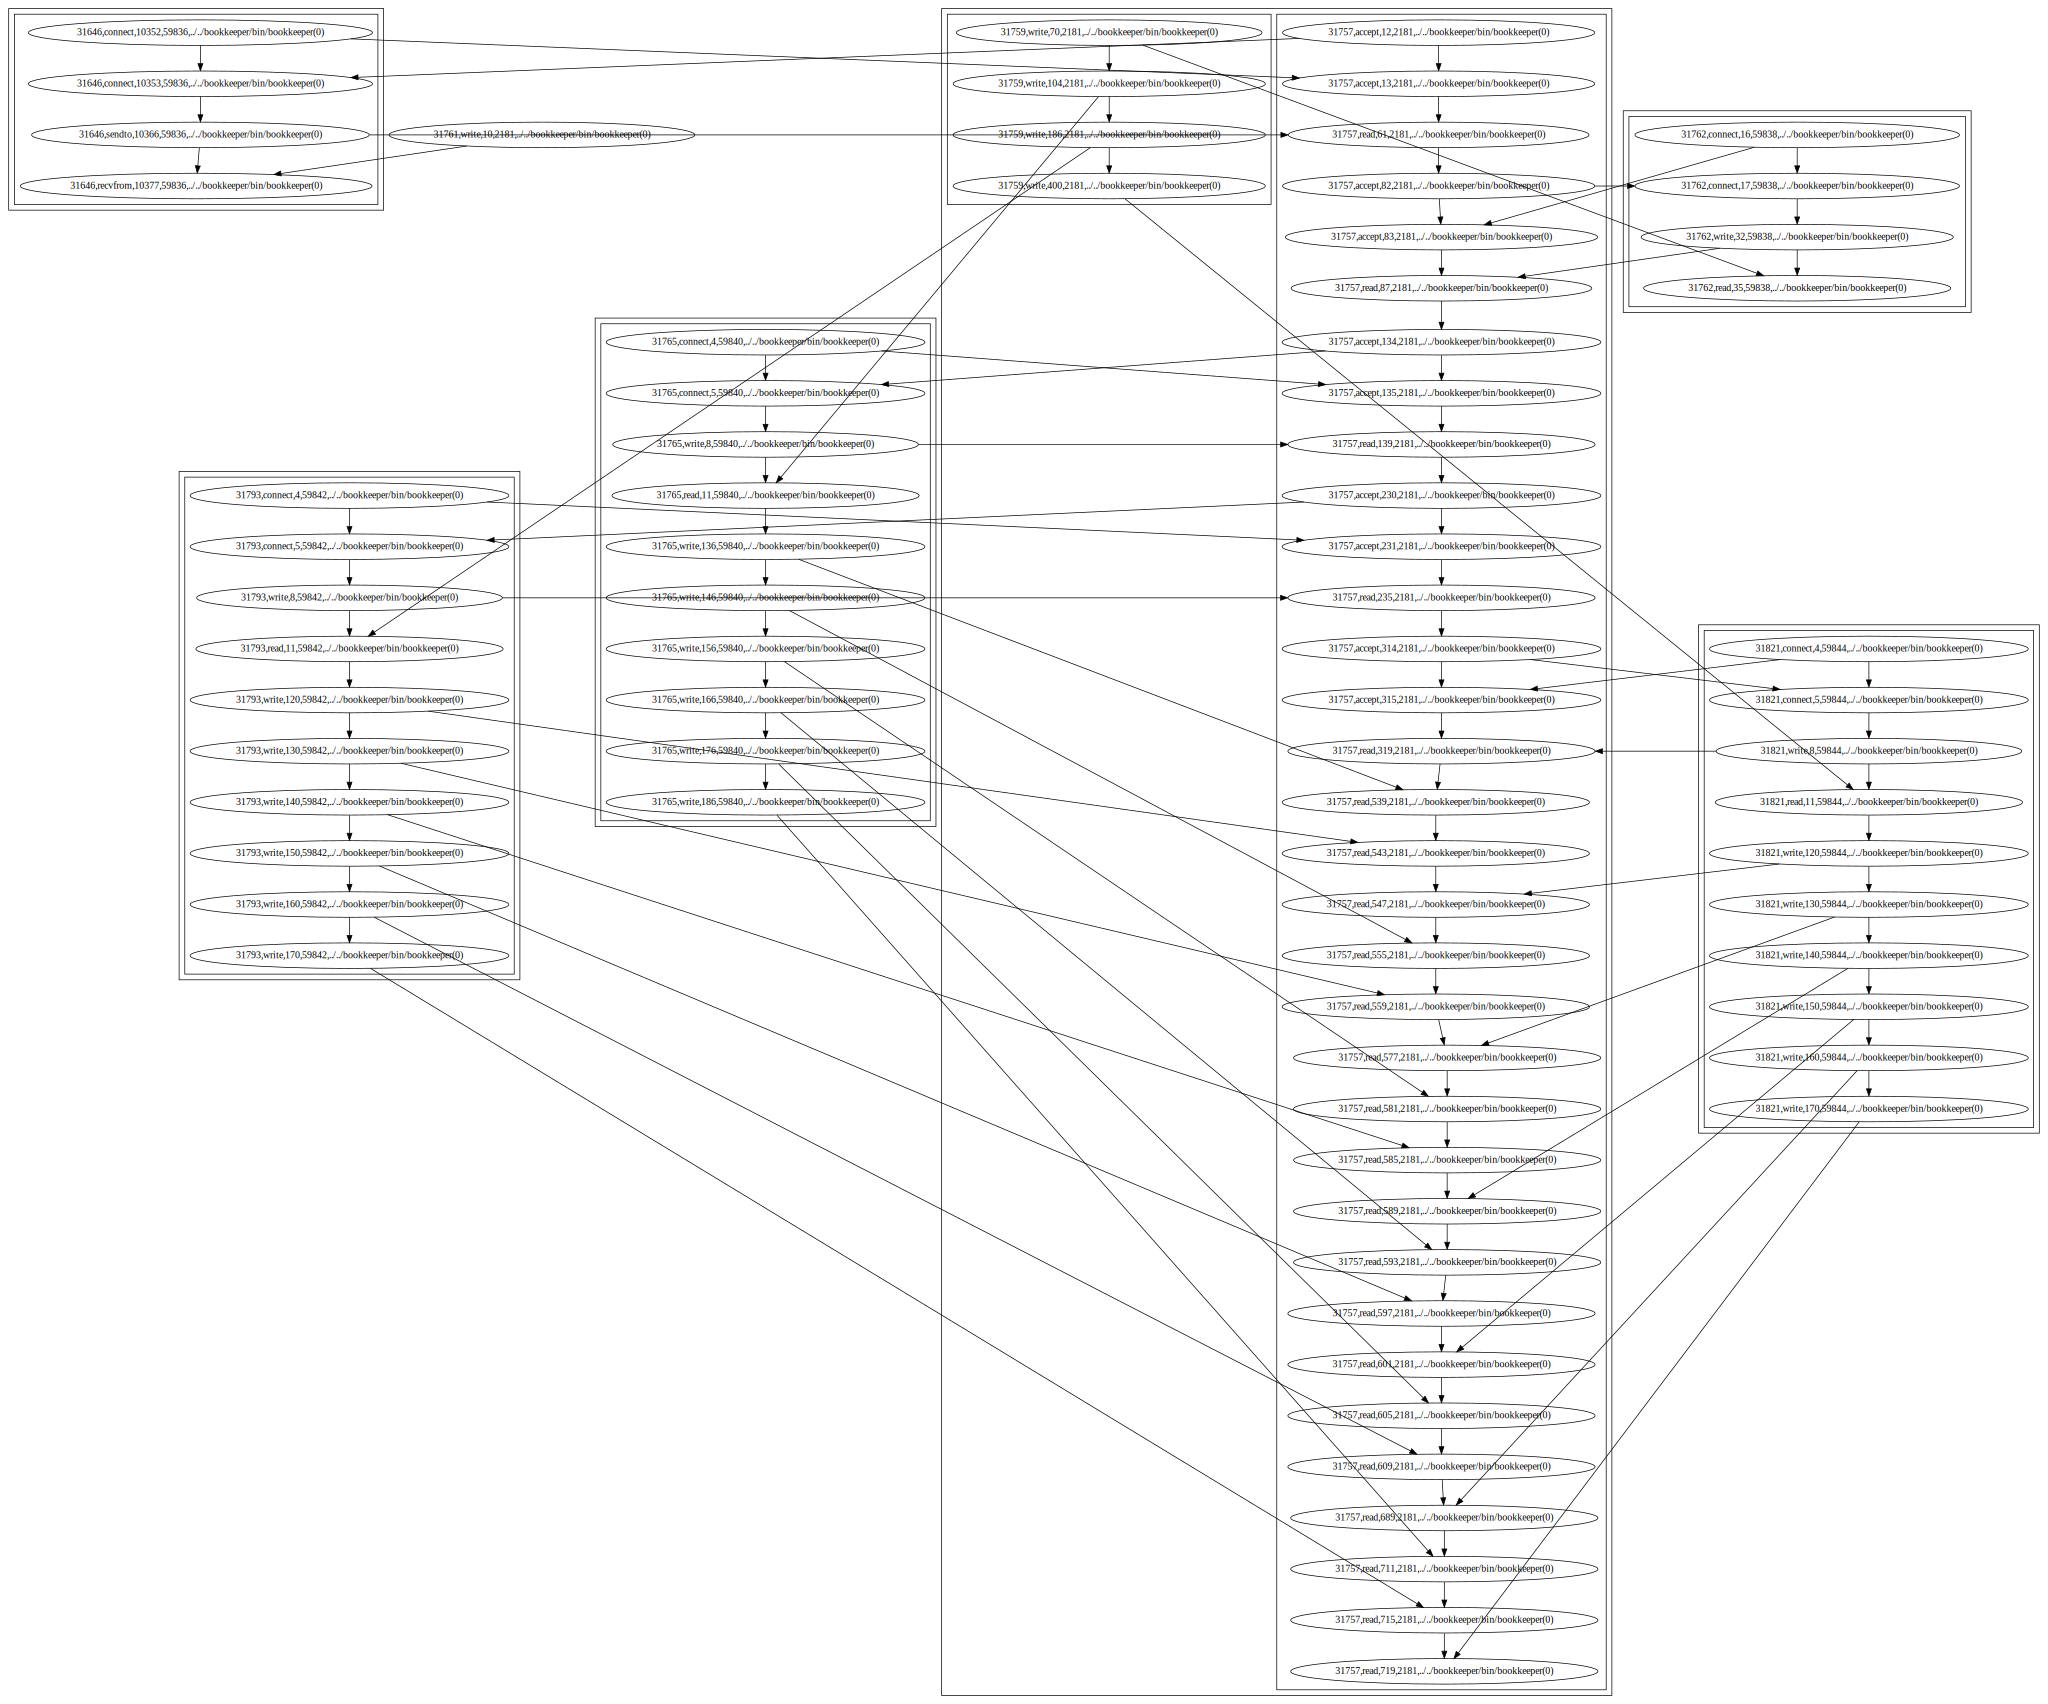

In [45]:
for idx,port in enumerate(frontier):
    nm = "cluster_" + str(port)
    #print("NAME is %s" % nm)
    with dot.subgraph(name = nm) as c:
        for thread in frontier[port]:
            snm = "cluster_" + str(thread)
            with c.subgraph(name=snm) as inner:
                last = None
                for event in sorted(frontier[port][thread], key=lambda x: int(x.split(',')[2])):
                    #print("event %s" % event)
                    if last is not None:
                        # go back and figure out the source of this duplication for write calls
                        if last != event:   
                            inner.edge(last, event, weight='2')
                            cg_nodes[last].add_child(cg_nodes[event])   
                    last = event
                    
#dot.render("foo2", view=True)
dot

In [46]:
# this is some wild imperative shit
possible_roots = []
for node in cg_nodes:
    print("LABELS %s", cg_nodes[node].labels)
    possible_roots.append(cg_nodes[node])

for node in cg_nodes:
    #print("NODE %s val %s" % (node, cg_nodes[node]))
    for child in cg_nodes[node].children:
        #print("DELETE %s" % child)
        if child in possible_roots:
            possible_roots.remove(child)
        else:
            print("missing child: %s" % child)

phony_root = CallGraph({'name': 'phony root'}) 
for root in possible_roots:
    #print("ROOT %s" % root)
    phony_root.add_child(root)

print("getting totality")
lbl_vals = phony_root.label_values()
print("done")

LABELS %s {'internal_uuid': '5516', 'issuing_thread_tid': '31646', 'issuing_process_pid': '31619', 'local_id': '2710725', 'syscall_number': '42', 'arg0': '123', 'arg1': '139794352677376', 'arg2': '16', 'arg3': '16', 'arg4': '0', 'arg5': '4273276392', 'retval': '0', 'was_successful': '0', 'command': 'accept', 'ip_port': '59836'}
LABELS %s {'internal_uuid': '5525', 'issuing_thread_tid': '31757', 'issuing_process_pid': '31619', 'local_id': '13810743', 'syscall_number': '43', 'arg0': '122', 'arg1': '139793065316736', 'arg2': '139789471307460', 'arg3': '16', 'arg4': '0', 'arg5': '4275964320', 'retval': '124', 'was_successful': '0', 'command': 'connect', 'ip_port': '2181'}
LABELS %s {'internal_uuid': '5538', 'issuing_thread_tid': '31646', 'issuing_process_pid': '31619', 'local_id': '2710768', 'syscall_number': '45', 'arg0': '123', 'arg1': '139794352611584', 'arg2': '8192', 'arg3': '0', 'arg4': '0', 'arg5': '0', 'retval': '273', 'was_successful': '0', 'command': 'write', 'ip_port': '59836'}
L

missing child: {'internal_uuid': '5557', 'issuing_thread_tid': '31757', 'issuing_process_pid': '31619', 'local_id': '13810806', 'syscall_number': '0', 'arg0': '124', 'arg1': '139793065324496', 'arg2': '4', 'arg3': '16', 'arg4': '0', 'arg5': '4273996888', 'retval': '4', 'was_successful': '0', 'command': 'sendto', 'ip_port': '2181'}({'internal_uuid': '5806', 'issuing_thread_tid': '31757', 'issuing_process_pid': '31619', 'local_id': '13811305', 'syscall_number': '43', 'arg0': '122', 'arg1': '139793065325632', 'arg2': '139789471307460', 'arg3': '16', 'arg4': '0', 'arg5': '4275964320', 'retval': '127', 'was_successful': '0', 'command': 'connect', 'ip_port': '2181'}({'internal_uuid': '5806', 'issuing_thread_tid': '31757', 'issuing_process_pid': '31619', 'local_id': '13811305', 'syscall_number': '43', 'arg0': '122', 'arg1': '139793065325632', 'arg2': '139789471307460', 'arg3': '16', 'arg4': '0', 'arg5': '4275964320', 'retval': '127', 'was_successful': '0', 'command': 'connect', 'ip_port': '21

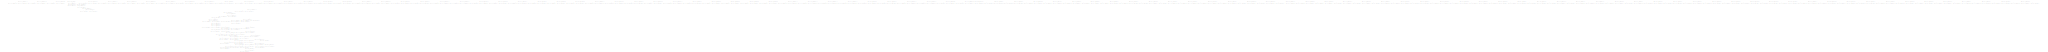

In [47]:
rules = {
    'command': lambda x,y: x,
    'ip_port': lambda x,y: x,
    'internal_uuid': index_of_memo,
    'local_id': index_of_memo
}

new_root = phony_root.transform(rules, lbl_vals).collapse()
dt = Digraph(strict=True)
new_root.todot(dt)
#dt.render("baR", view=True)
dt